**Imports**

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os,cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from pylab import rcParams
rcParams['figure.figsize'] = 20, 10
import keras
from keras.utils import np_utils
from keras.models import Sequential
from keras.models import model_from_json
from keras.layers import Dense , Activation , Dropout ,Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.metrics import categorical_accuracy
from keras.optimizers import *
from keras.wrappers.scikit_learn import KerasClassifier
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import cross_val_score, cross_val_predict, train_test_split, KFold, LeaveOneOut
from sklearn.datasets import make_classification
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix
import seaborn as sns

**Mount Drive**

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
!ls

CK+48


In [ ]:
%cd drive/MyDrive/Dataset/

/content/drive/MyDrive/Dataset


**Load images**

In [ ]:
ck_path = 'CK+48'
data_dir_list = os.listdir(ck_path)

def load_image(dataset, img):
  input_img=cv2.imread(ck_path + '/'+ dataset + '/'+ img )
  input_img_resize=cv2.resize(input_img,(48,48))
  return input_img

img_data_list=[load_image(dataset, img) for dataset in data_dir_list for img in os.listdir(ck_path+'/'+ dataset)]
        
img_data = np.array(img_data_list)
img_data = img_data.astype('float32')
img_data = img_data/255
img_data.shape


(981, 48, 48, 3)

**Label the images**

In [ ]:
num_classes = 7

num_of_samples = img_data.shape[0]
labels = np.ones((num_of_samples,),dtype='int32')

labels[0:134]   = 0   #135
labels[135:188] = 1 #54
labels[189:365] = 2 #177
labels[366:440] = 3 #75
labels[441:647] = 4 #207
labels[648:731] = 5 #84
labels[732:980] = 6 #249

names = ['anger','contempt','disgust','fear','happy','sadness','surprise']

def getLabel(id):
    return names[id]

**Splitting test**

In [ ]:
Y = np_utils.to_categorical(labels, num_classes)

#Shuffle the dataset
x,y = shuffle(img_data,Y, random_state=2)
# Split the dataset
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=2)

**Model Creation**

In [ ]:
def create_model():
    input_shape=(48,48,3)

    model = Sequential()
    model.add(Conv2D(6, (5, 5), input_shape=input_shape, padding='same', activation = 'relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(16, (5, 5), padding='same', activation = 'relu'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(64, (3, 3), activation = 'relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(128, activation = 'relu'))
    model.add(Dropout(0.5))
    model.add(Dense(7, activation = 'softmax'))

    model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='RMSprop')
    
    return model

model_custom = create_model()
model_custom.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 48, 48, 6)         456       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 24, 24, 6)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 16)        2416      
_________________________________________________________________
activation (Activation)      (None, 24, 24, 16)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 10, 10, 64)        9280      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 5, 5, 64)          0

**Visualize the network**

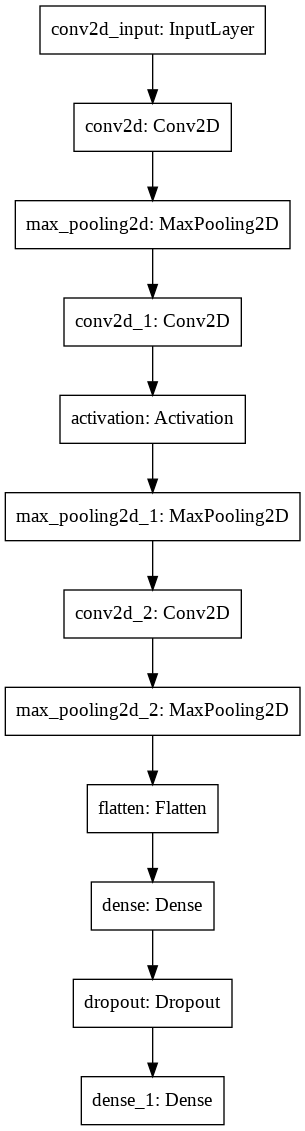

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(model_custom, to_file='model.png')

**Cross Validation**

In [ ]:
kf = KFold(n_splits=5, shuffle=False)
#loo = LeaveOneOut()

**Data Augmentation**

In [ ]:
aug = ImageDataGenerator(
    rotation_range=25, 
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2, 
    zoom_range=0.2,
    horizontal_flip=True, 
    fill_mode="nearest")

**Training**

In [ ]:
# epochs count
EPOCHS = 200

result = []
scores_loss = []
scores_acc = []
k_no = 0
for train_index, test_index in kf.split(x_train):
    X_Train_ = x[train_index]
    Y_Train = y[train_index]
    X_Test_ = x[test_index]
    Y_Test = y[test_index]

    file_path = "training/cnn/weights_best_"+str(k_no)+".hdf5"
    checkpoint = ModelCheckpoint(file_path, monitor='loss', verbose=1, save_best_only=True, mode='min')
    early = EarlyStopping(monitor="loss", mode="min", patience=10)

    callbacks_list = [checkpoint, early]

    model = create_model()
    hist = model.fit_generator(aug.flow(X_Train_, Y_Train), epochs=EPOCHS,validation_data=(X_Test_, Y_Test), callbacks=callbacks_list, verbose=0)
    # model.fit(X_Train, Y_Train, batch_size=batch_size, epochs=epochs, validation_data=(X_Test, Y_Test), verbose=1)
    model.load_weights(file_path)
    result.append(model.predict(X_Test_))
    score = model.evaluate(X_Test_,Y_Test, verbose=0)
    scores_loss.append(score[0])
    scores_acc.append(score[1])
    k_no+=1

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1915: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '



Epoch 00001: loss improved from inf to 1.88770, saving model to training/cnn/weights_best_0.hdf5

Epoch 00002: loss improved from 1.88770 to 1.85465, saving model to training/cnn/weights_best_0.hdf5

Epoch 00003: loss improved from 1.85465 to 1.83410, saving model to training/cnn/weights_best_0.hdf5

Epoch 00004: loss improved from 1.83410 to 1.81187, saving model to training/cnn/weights_best_0.hdf5

Epoch 00005: loss improved from 1.81187 to 1.70611, saving model to training/cnn/weights_best_0.hdf5

Epoch 00006: loss improved from 1.70611 to 1.56257, saving model to training/cnn/weights_best_0.hdf5

Epoch 00007: loss improved from 1.56257 to 1.51894, saving model to training/cnn/weights_best_0.hdf5

Epoch 00008: loss improved from 1.51894 to 1.41664, saving model to training/cnn/weights_best_0.hdf5

Epoch 00009: loss improved from 1.41664 to 1.38996, saving model to training/cnn/weights_best_0.hdf5

Epoch 00010: loss improved from 1.38996 to 1.34449, saving model to training/cnn/weig

In [ ]:
print(scores_acc,scores_loss)

[0.8027210831642151, 0.795918345451355, 0.8231292366981506, 0.7482993006706238, 0.8095238208770752] [0.4991573393344879, 0.4771060645580292, 0.42044273018836975, 0.763699471950531, 0.36612093448638916]


In [ ]:
value_min = min(scores_loss)
value_index = scores_loss.index(value_min)
print(value_index)

4


In [ ]:
model.load_weights("training/cnn/weights_best_"+str(value_index)+".hdf5")
best_model = model

In [ ]:
score = best_model.evaluate(x_test, y_test, verbose=0)
print('Test Loss:', score[0])
print('Test accuracy:', score[1])

test_image = x_test[0:1]
print (test_image.shape)

print(best_model.predict(test_image))
print(best_model.predict_classes(test_image))
print(y_test[0:1])

#predict
y_pred = best_model.predict(x_test)

Test Loss: 0.3191903829574585
Test accuracy: 0.8658536672592163
(1, 48, 48, 3)
[[3.5487884e-01 6.1843242e-03 3.8312780e-04 5.6690866e-01 6.2825918e-02
  2.9323282e-04 8.5259452e-03]]
[3]
[[1. 0. 0. 0. 0. 0. 0.]]


/usr/local/lib/python3.7/dist-packages/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.


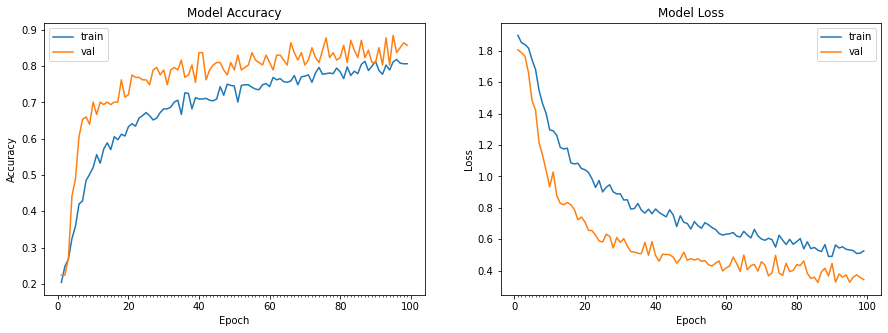

In [ ]:
# visualizing losses and accuracy
%matplotlib inline
def plot_model_history(model_history):
    """
    Plot Accuracy and Loss curves given the model_history
    """
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['accuracy'])+1),model_history.history['accuracy'])
    axs[0].plot(range(1,len(model_history.history['val_accuracy'])+1),model_history.history['val_accuracy'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['accuracy'])+1),len(model_history.history['accuracy'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    fig.savefig('plot.png')
    plt.show()


plot_model_history(hist)

In [ ]:
!ls

CK+48  model.png


In [ ]:
#Model Save
try:
  os.mkdir('best_model')
except:
  pass
best_model.save_weights('best_model/model_weights.h5')
best_model.save('best_model/model_keras.h5')

**Confusion Matrix**

In [ ]:
results = best_model.predict_classes(x_test)
cm = confusion_matrix(np.where(y_test == 1)[1], results)

cm_df = pd.DataFrame(cm, index = names,
                     columns = names
                    )
cm_df

/usr/local/lib/python3.7/dist-packages/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


,anger,contempt,disgust,fear,happy,sadness,surprise
anger,33,0,0,2,0,0,0
contempt,10,2,1,0,0,0,0
disgust,6,4,39,0,0,6,0
fear,0,0,0,10,0,0,0
happy,0,0,0,0,45,0,0
sadness,1,0,0,0,0,13,0
surprise,2,0,0,1,0,0,71


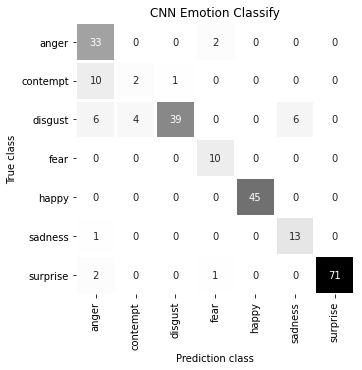

In [ ]:
plt.figure(figsize = (5,5))
sns.heatmap(cm_df, annot = True,cmap='Greys',cbar=False,linewidth=2,fmt='d')
plt.title('CNN Emotion Classify')
plt.ylabel('True class')
plt.xlabel('Prediction class')
plt.show()